In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.constants import G
from astropy import units as u
from scipy.integrate import quad
import symlib
import os
from glob import glob
import seaborn as sns
from scipy.stats import spearmanr
from scipy.optimize import curve_fit   
from scipy.interpolate import interp1d

base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster", "SymphonyCluster"]
sim_colors = {
        "SymphonyLMC": sns.color_palette("colorblind")[4],
        "SymphonyMilkyWay": sns.color_palette("colorblind")[0],
        "SymphonyGroup": sns.color_palette("colorblind")[2],
        "SymphonyLCluster": sns.color_palette("colorblind")[1],
        "SymphonyCluster": sns.color_palette("colorblind")[3],
    }
sim_names = {
        "SymphonyLMC": "LMC",
        "SymphonyMilkyWay": "Milky~Way",
        "SymphonyGroup": "Group",
        "SymphonyLCluster": "L-Cluster",
        "SymphonyCluster": "Cluster",
    }
mean_cvir = {
    "SymphonyLMC": 12.2,
    "SymphonyMilkyWay": 10.8,
    "SymphonyGroup": 9.0,
    "SymphonyLCluster": 5.0,
    "SymphonyCluster": 5.6,
}
out_dir = os.path.join(base_dir, "output", "FIGURE")

In [ ]:
G = 1 

def sci_notation_latex(x, precision=2):

    fmt = f"{x:.{precision}e}"
    base, exponent = fmt.split("e")
    return rf"{base} \times 10^{{{int(exponent)}}}"

def compute_eta_from_scaled_profiles(r, rho, m_enc, sigma_r, sigma_tan):
    dr = np.gradient(r)
    vol = 4 * np.pi * r**2

    sigma2_tot = sigma_r**2 + sigma_tan**2

    # Scaled kinetic energy
    integrand_K = 0.5 * rho * sigma2_tot * vol
    K = np.sum(integrand_K * dr)

    # Scaled potential energy
    integrand_U = -m_enc * rho / r * vol
    U = np.sum(integrand_U * dr)

    if U >= 0 or K <= 0:
        return np.nan
    return 2 * K / abs(U)

def compare_normalized_jeans_deviation_vs_virial_ratio():

    delta_J_list = []
    eta_list     = []
    mass_list    = []

    # 1) Gather raw δJ, η, and M_vir for all halos
    for suite in suite_names:
        density_dir = os.path.join(base_dir, "output", suite, "density_profiles")
        velocity_dir = os.path.join(base_dir, "output", suite, "velocity_profiles")
        mass_dir    = os.path.join(base_dir, "output", suite, "mass_profiles")
        jeans_path  = os.path.join(base_dir, "output", suite, "jeans_deviation_total.csv")
        mass_path   = os.path.join(base_dir, "output", suite, "halo_mass.csv")

        # load δJ_tot per halo
        df_jeans = pd.read_csv(jeans_path)
        jeans_dict = dict(zip(df_jeans["halo_id"],
                              pd.to_numeric(df_jeans["delta_J_tot"], errors='coerce')))
        # load M_vir per halo
        df_mass = pd.read_csv(mass_path)
        mass_dict = dict(zip(df_mass["halo_id"],
                             pd.to_numeric(df_mass["mvir"], errors='coerce')))

        # loop through each halo’s density file to compute η
        for fname in sorted(os.listdir(density_dir)):
            if not fname.endswith(".csv"):
                continue
            try:
                halo_id = int(fname.split("_")[1])
                if halo_id not in jeans_dict or halo_id not in mass_dict:
                    continue

                # read profiles
                df_rho = pd.read_csv(os.path.join(density_dir, fname))
                df_vel = pd.read_csv(os.path.join(velocity_dir, fname))
                df_menc= pd.read_csv(os.path.join(mass_dir, fname))

                r      = pd.to_numeric(df_rho["r_scaled"], errors='coerce').values
                rho    = pd.to_numeric(df_rho["rho_scaled"], errors='coerce').values
                m_enc  = pd.to_numeric(df_menc["m_scaled"], errors='coerce').values
                sigma_r   = pd.to_numeric(df_vel["sigma_rad_scaled"], errors='coerce').values
                sigma_tan = pd.to_numeric(df_vel["sigma_tan_scaled"], errors='coerce').values

                # require matching lengths
                if not (len(r)==len(rho)==len(m_enc)==len(sigma_r)==len(sigma_tan)):
                    continue

                # compute virial ratio η = 2K/|U|
                eta = compute_eta_from_scaled_profiles(r, rho, m_enc, sigma_r, sigma_tan)
                delta_J = jeans_dict[halo_id]
                mvir    = mass_dict[halo_id]

                if np.isfinite(eta) and np.isfinite(delta_J) and np.isfinite(mvir):
                    eta_list.append(eta)
                    delta_J_list.append(delta_J)
                    mass_list.append(mvir)

            except Exception as e:
                print(f"[Warning] failed to process {suite} halo {fname}: {e}")

    # convert to arrays
    delta_J_arr = np.array(delta_J_list)
    eta_arr     = np.array(eta_list)
    logM_arr    = np.log10(np.array(mass_list))

    # check we have enough halos
    if delta_J_arr.size < 5:
        print("[Warning] Too few halos for meaningful correlation.")
        return

    # 2) normalize δJ by median and std
    med_J = np.median(delta_J_arr)
    std_J = np.std(delta_J_arr)
    if std_J <= 0:
        print("[Warning] zero variance in Jeans deviation; cannot normalize.")
        return
    delta_J_norm = (delta_J_arr - med_J) / std_J

    # 3) compute Spearman correlation
    rho_s, p_s = spearmanr(delta_J_norm, eta_arr)

    # 4) plotting
    plt.rcParams['text.usetex'] = True
    plt.figure(figsize=(7,6), dpi=500)
    sc = plt.scatter(
        delta_J_norm, eta_arr,
        c=logM_arr, cmap="viridis", s=25, alpha=0.8, edgecolors="none"
    )
    plt.axhline(1.0, color="gray", linestyle="--", label=r"Virial equilibrium (\eta=1)")
    cbar = plt.colorbar(sc)
    cbar.set_label(r"$\log_{10}(M_{\rm vir}/M_\odot)$", fontsize=14)

    plt.xlabel(r"$\Delta \delta_J / \sigma_{\delta_J}$", fontsize=18)
    plt.ylabel(r"$\eta = \frac{2K}{|U|}$", fontsize=18)
    plt.grid(True, linestyle=":")
    plt.legend(loc="upper right", fontsize=18)

    txt = rf"$\rho = {rho_s:.3f}$" + "\n" + rf"$p = {sci_notation_latex(p_s)}$"
    plt.text(0.95, 0.05, txt,
             transform=plt.gca().transAxes,
             ha='right', va='bottom',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.5),
             fontsize=15)
    plt.savefig(os.path.join(out_dir, f"delta_jeans_vs_eta.pdf"))
    plt.tight_layout()
    plt.show()

compare_normalized_jeans_deviation_vs_virial_ratio()


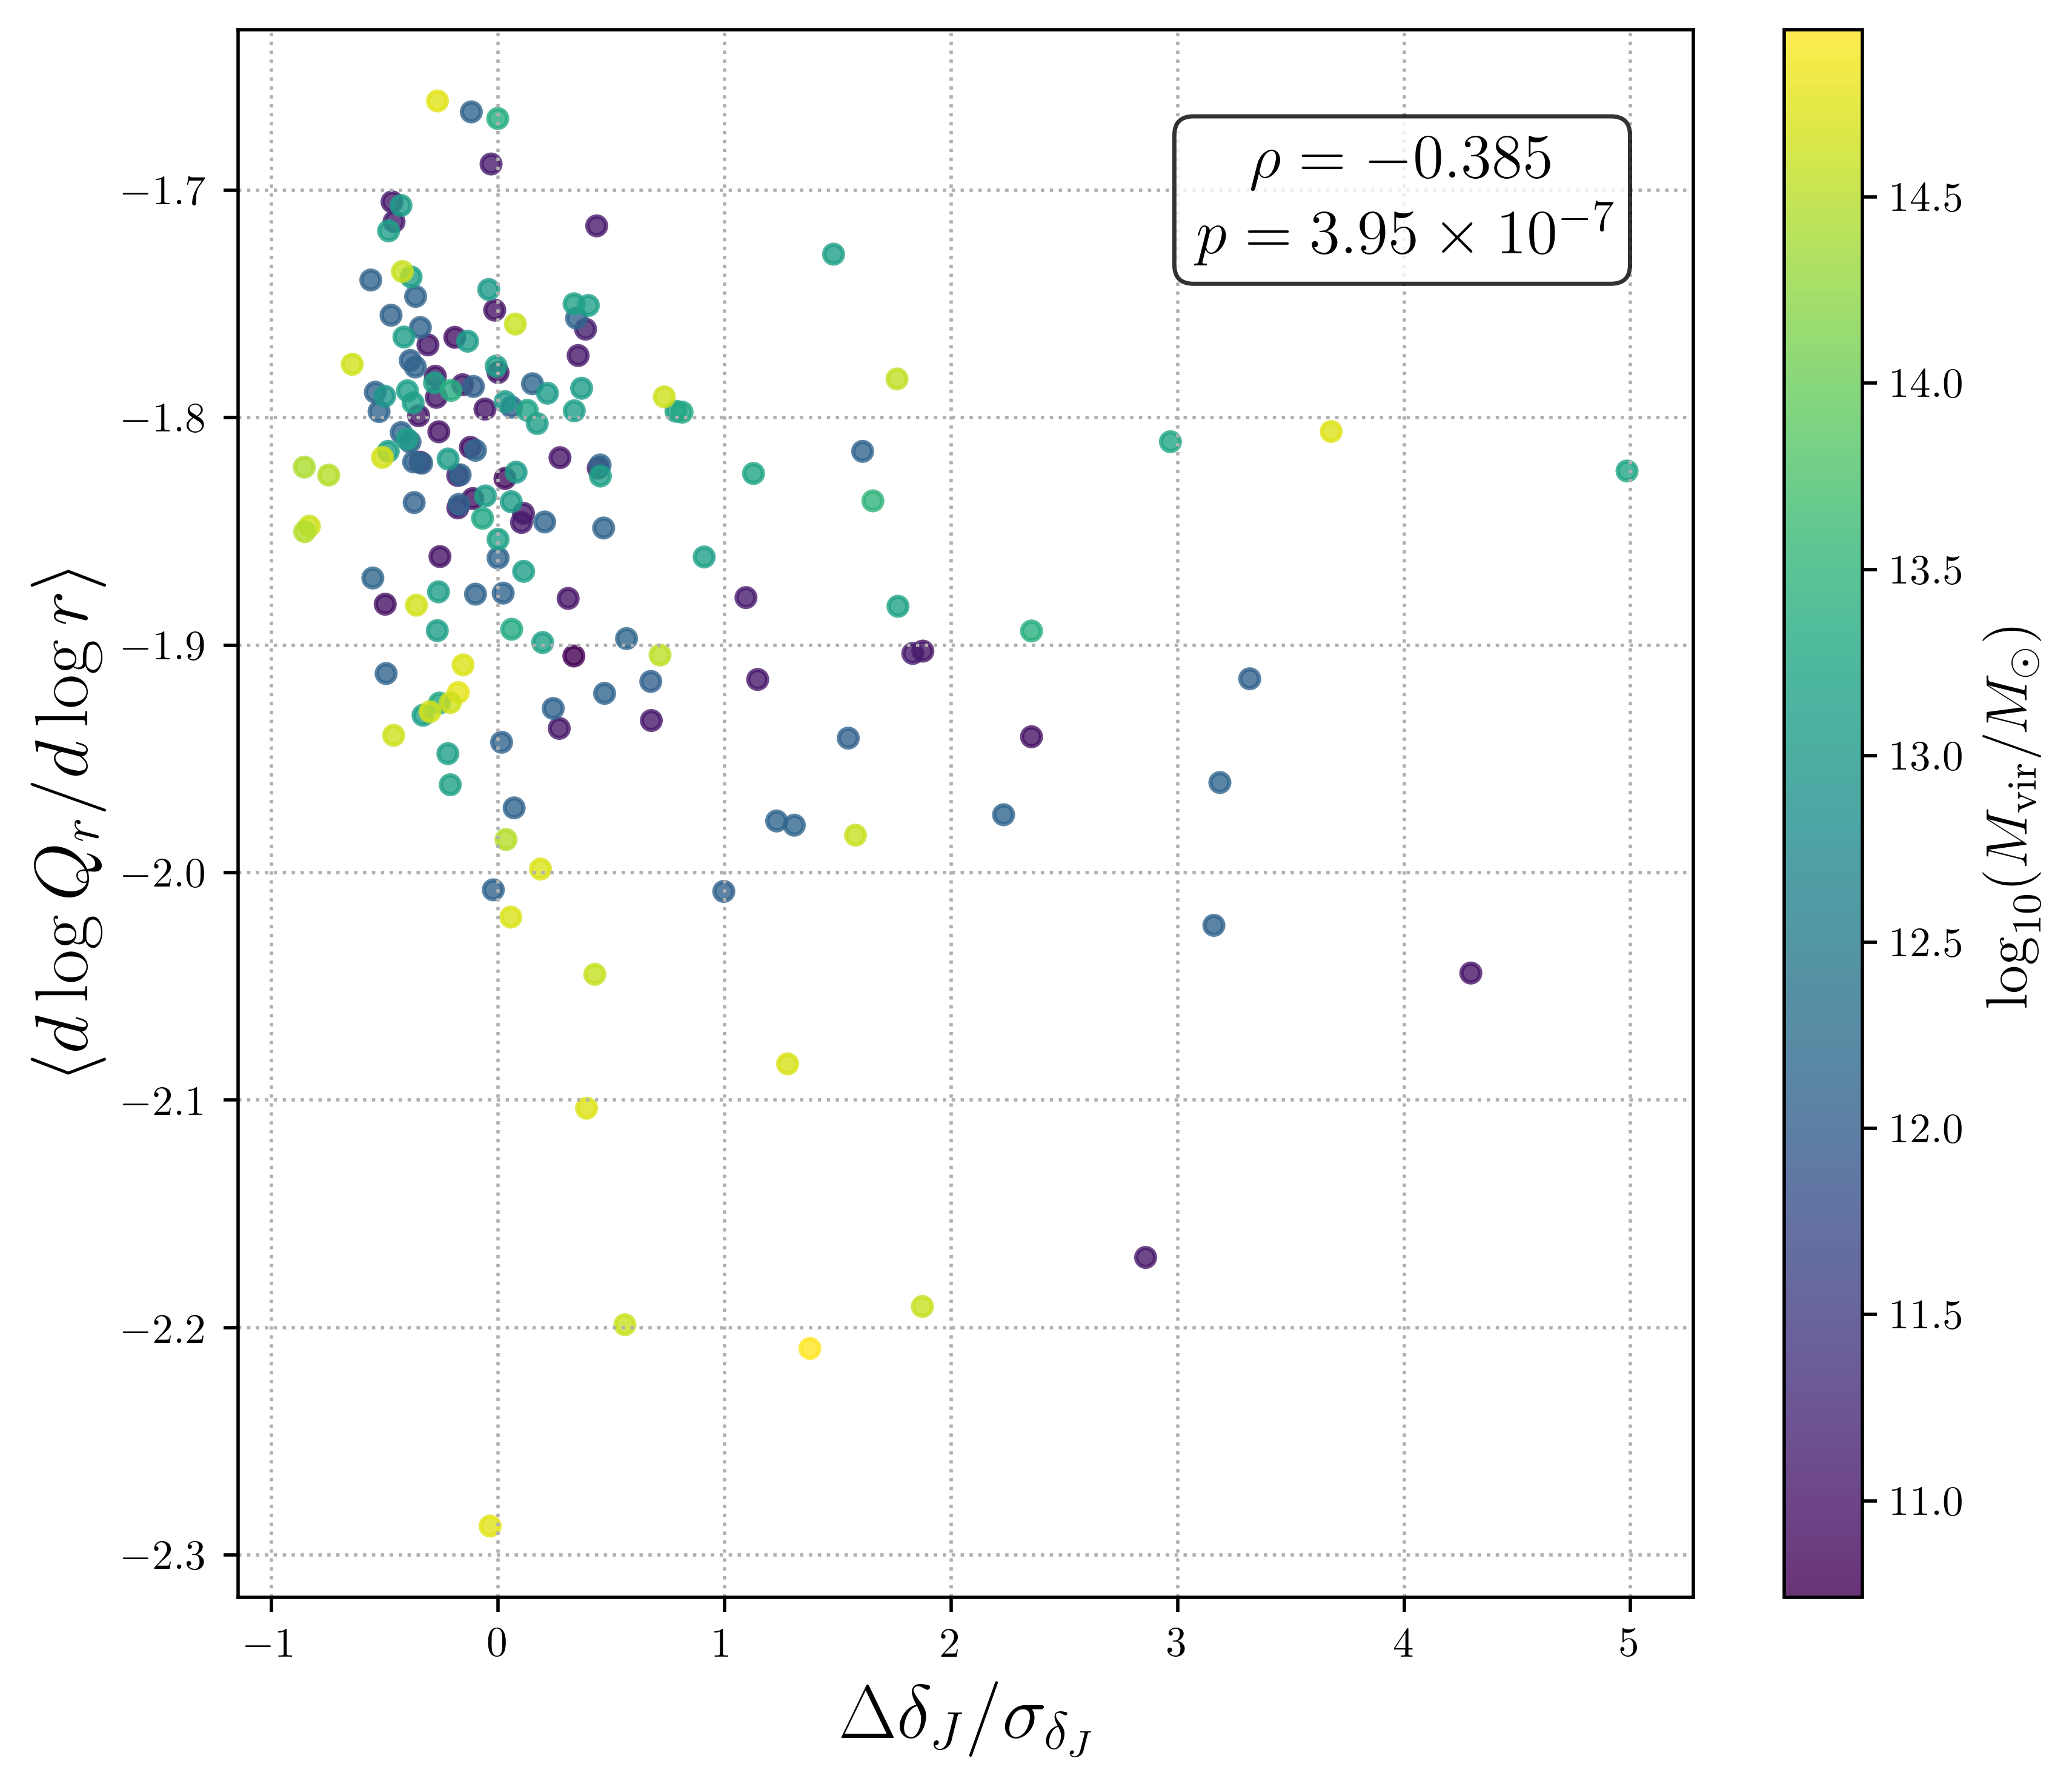

In [9]:
def const_model(r, a):
    """A one-parameter constant model: y(r) = a."""
    return a * np.ones_like(r)

def plot_bestfit_ppsd_slope_vs_jeans_deviation_norm(r_fit_range= (0.01, 1.0)): 
    slope_vals, jeans_norm_vals, log_mass_vals = [], [], []

    for suite in suite_names:
        slope_dir  = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_r")
        jeans_path = os.path.join(base_dir, "output", suite, "jeans_deviation_total.csv")
        mass_path  = os.path.join(base_dir, "output", suite, "halo_mass.csv")

        df_jeans = pd.read_csv(jeans_path)
        dJ       = pd.to_numeric(df_jeans["delta_J_tot"], errors="coerce")
        median_j, std_j = np.nanmedian(dJ), np.nanstd(dJ)
        jeans_norm = {hid: (dj - median_j) / std_j for hid, dj in zip(df_jeans["halo_id"], dJ)}

        df_mass  = pd.read_csv(mass_path)
        mass_map = dict(zip(df_mass["halo_id"], pd.to_numeric(df_mass["mvir"], errors="coerce")))

        for fname in sorted(f for f in os.listdir(slope_dir) if f.endswith(".csv")):
            try:
                hid = int(fname.split("_")[1]) 
            except Exception:
                continue

            try:
                df = pd.read_csv(os.path.join(slope_dir, fname))
                r  = pd.to_numeric(df["r_scaled"], errors="coerce").to_numpy(float)
                s  = pd.to_numeric(df["slope_Q_r"], errors="coerce").to_numpy(float)

                mask = (r >= r_fit_range[0]) & (r <= r_fit_range[1]) & np.isfinite(s)
                if mask.sum() < 5:
                    continue  # not enough points for a stable fit

                r_fit, s_fit = r[mask], s[mask]

                try:
                    popt, _ = curve_fit(const_model, r_fit, s_fit, p0=[np.median(s_fit)])
                    best_slope = popt[0]
                except Exception:
                    best_slope = np.median(s_fit)

                dj_norm = jeans_norm.get(hid, np.nan)
                mvir    = mass_map.get(hid,  np.nan)

                if np.isfinite(best_slope) and np.isfinite(dj_norm):
                    slope_vals.append(best_slope)
                    jeans_norm_vals.append(dj_norm)
                    log_mass_vals.append(np.log10(mvir) if np.isfinite(mvir) else np.nan)

            except Exception as err:
                print(f"[Warning] {suite}/{fname}: {err}")

    slope_vals, jeans_norm_vals, log_mass_vals = map(np.asarray, (slope_vals, jeans_norm_vals, log_mass_vals))

    rho, pval = spearmanr(jeans_norm_vals, slope_vals)

    plt.figure(figsize=(7, 6), dpi=500)
    plt.rcParams['text.usetex'] = True
    sc = plt.scatter(jeans_norm_vals, slope_vals, c=log_mass_vals,
                     cmap="viridis", s=20, alpha=0.8)
    cbar = plt.colorbar(sc)
    cbar.set_label(r"$\log_{10}(M_{\rm vir}/M_\odot)$", fontsize=14)
    plt.xlabel(r"$\Delta \delta_J / \sigma_{\delta_J}$", fontsize=18)
    plt.ylabel(r"$\langle d\log Q_r / d\log r\rangle$", fontsize=18)
    txt = rf"$\rho = {rho:.3f}$" + "\n" + rf"$p = {sci_notation_latex(pval)}$"
    plt.gca().text(0.8, 0.85, txt, transform=plt.gca().transAxes,
                   ha="center", va="bottom",
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),fontsize=15)
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"ppsd_slope_vs_delta_jeans.pdf"))
    plt.show()

suite_names = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster"]
plot_bestfit_ppsd_slope_vs_jeans_deviation_norm(r_fit_range=(5e-3, 1.2))


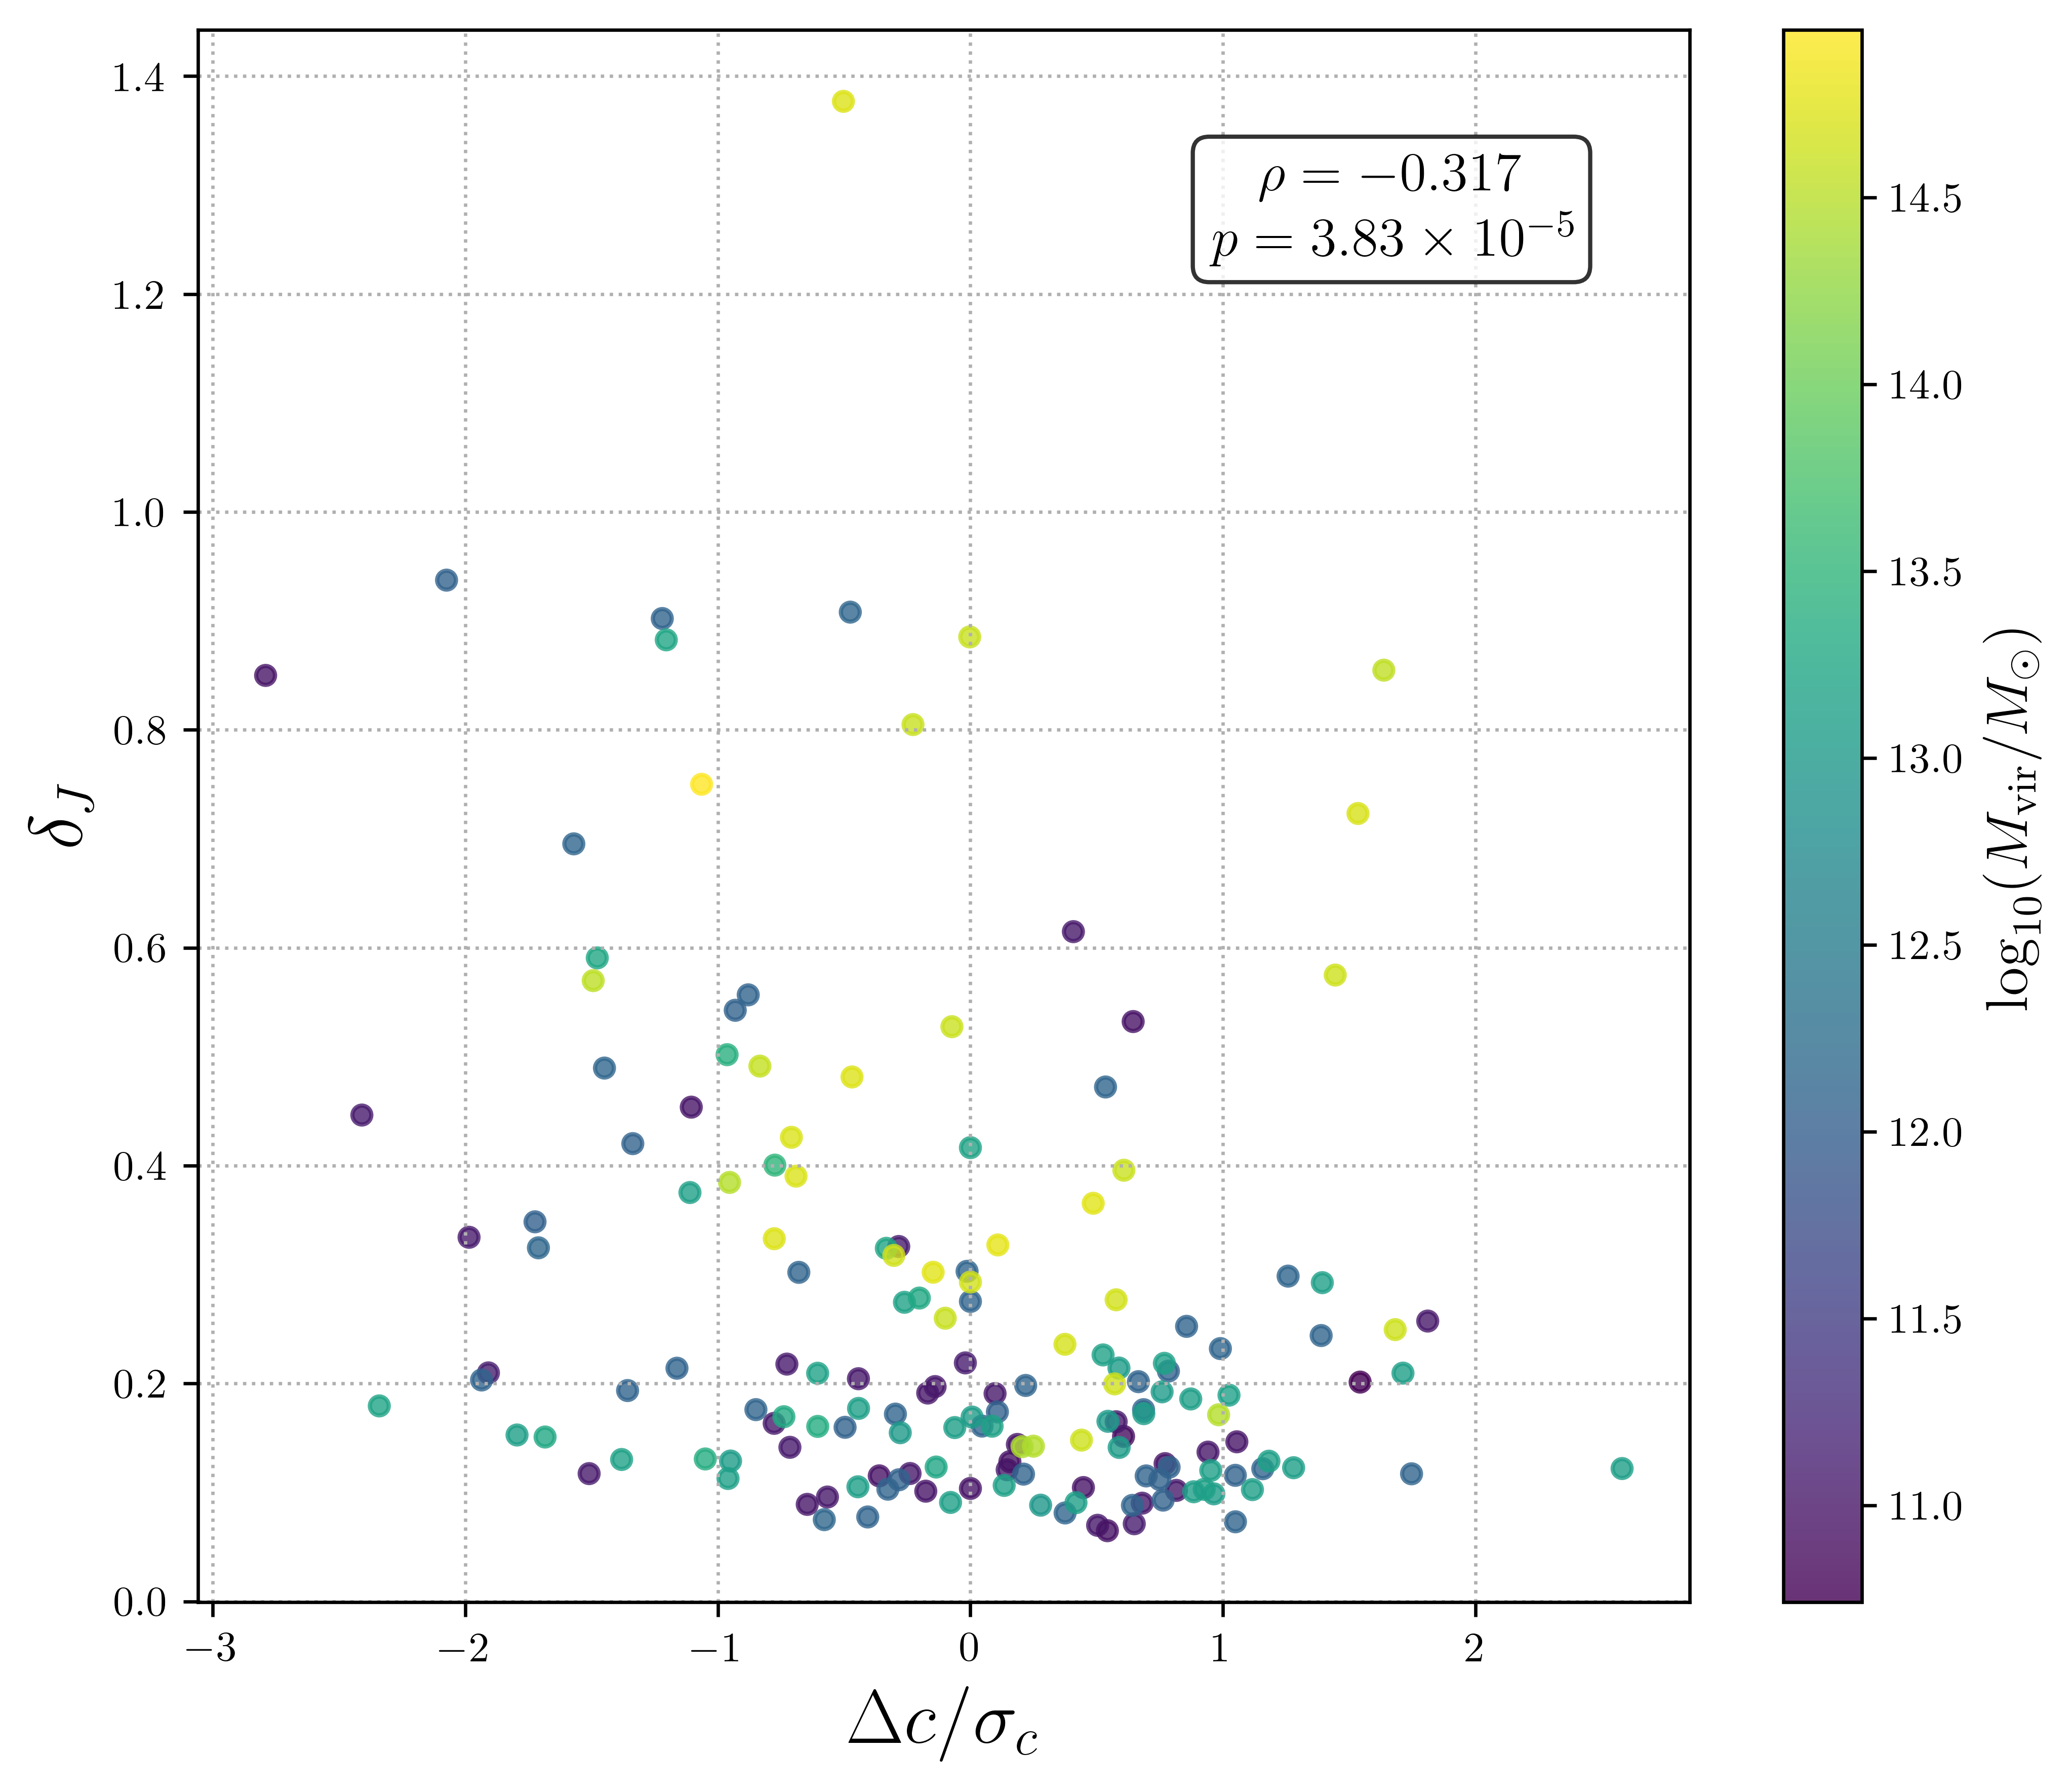

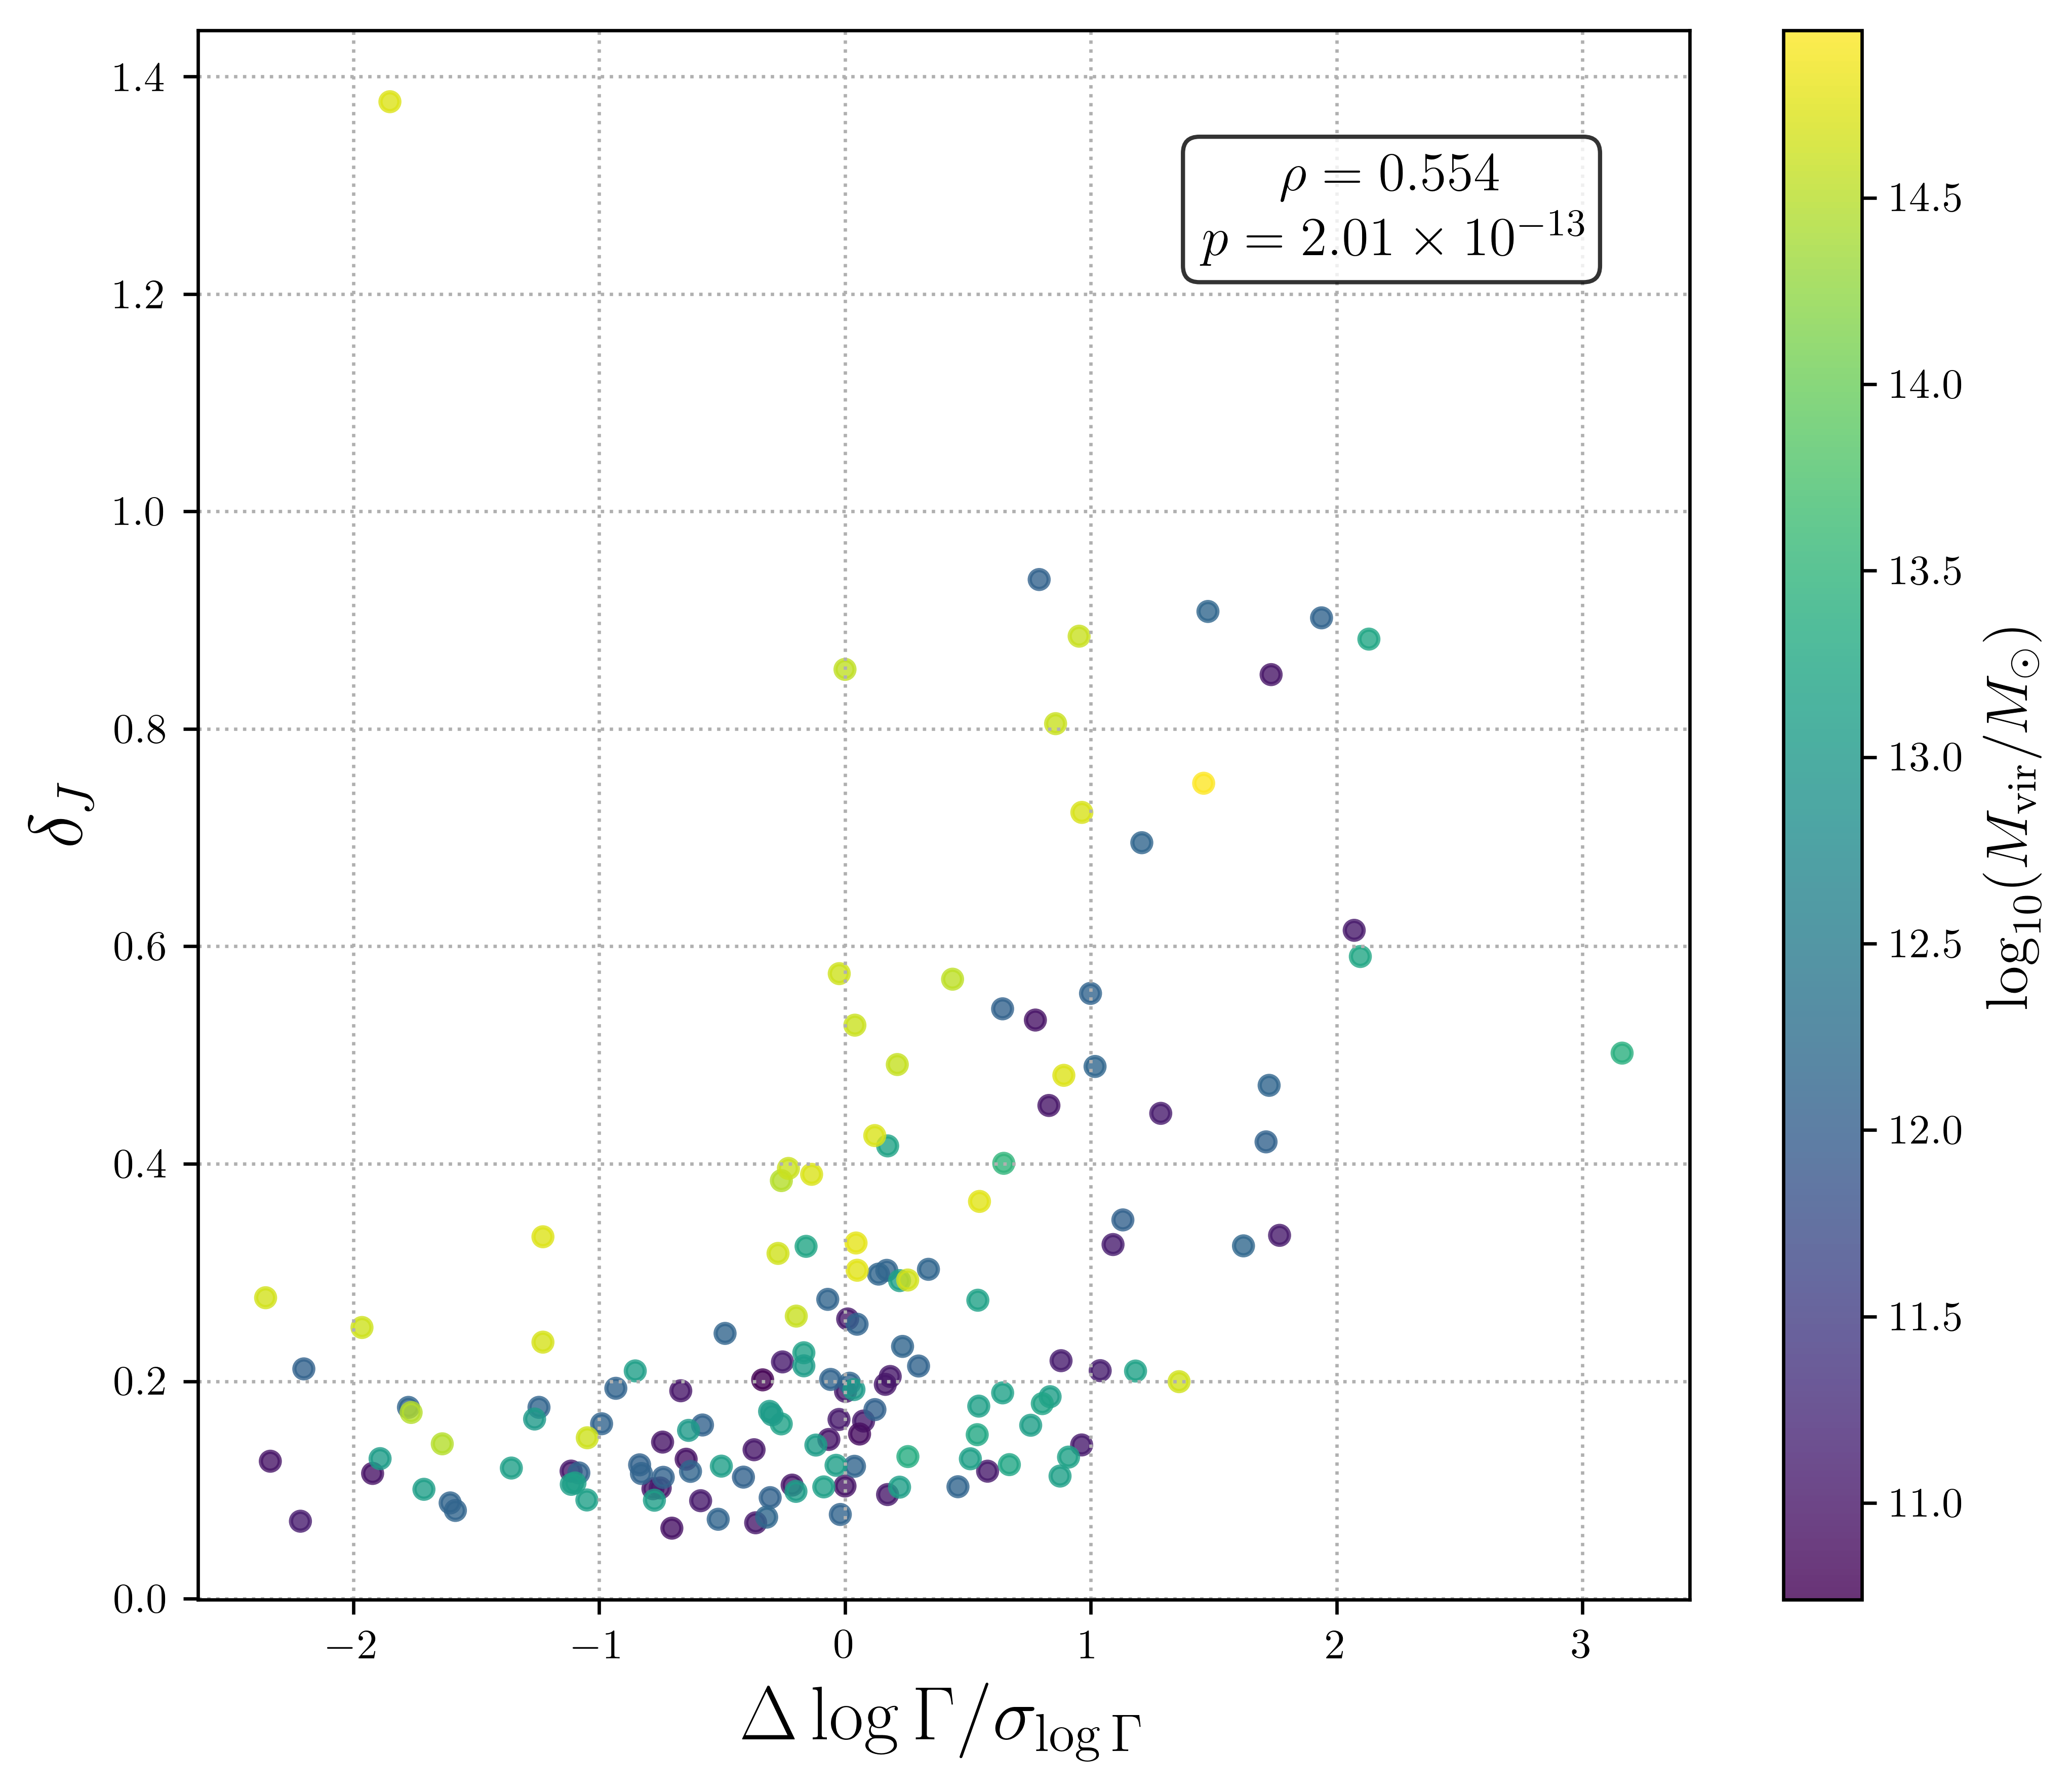

In [15]:
def quantify_jeans_vs_cgamma(x_var="cvir"):
    x_vals, delta_j_vals, mass_vals = [], [], []

    for suite in suite_names:
        cvir_path = os.path.join(base_dir, "output", suite, "halo_concentrations.csv")
        gamma_path = os.path.join(base_dir, "output", suite, "accretion_rates.csv")
        mass_path = os.path.join(base_dir, "output", suite, "halo_mass.csv")
        jeans_path = os.path.join(base_dir, "output", suite, "jeans_deviation_total.csv")

        df_cvir = pd.read_csv(cvir_path)
        df_gamma = pd.read_csv(gamma_path)
        df_mass = pd.read_csv(mass_path)
        df_jeans = pd.read_csv(jeans_path)

        # Create lookup dictionaries
        cvir_dict = dict(zip(df_cvir["halo_id"], pd.to_numeric(df_cvir["cvir"], errors='coerce')))
        gamma_dict = dict(zip(df_gamma["halo_index"], pd.to_numeric(df_gamma["gamma"], errors='coerce')))
        mass_dict = dict(zip(df_mass["halo_id"], pd.to_numeric(df_mass["mvir"], errors='coerce')))
        delta_j_dict = dict(zip(df_jeans["halo_id"], pd.to_numeric(df_jeans["delta_J_tot"], errors='coerce')))

        # Normalized variables (computed within each suite)
        if x_var == "delta_c_norm":
            c_vals = df_cvir["cvir"].values
            c_med, c_std = np.nanmedian(c_vals), np.nanstd(c_vals)
            x_dict = {row["halo_id"]: (row["cvir"] - c_med) / c_std for _, row in df_cvir.iterrows()}

        elif x_var == "delta_gamma_norm":
            vals = df_gamma["gamma"].values
            valid_mask = (vals > 0) & np.isfinite(vals)
            log_vals = np.log10(vals[valid_mask])
            g_med, g_std = np.nanmedian(log_vals), np.nanstd(log_vals)
            x_dict = {
                row["halo_index"]: (np.log10(row["gamma"]) - g_med) / g_std
                for _, row in df_gamma.iterrows()
                if row["gamma"] > 0 and np.isfinite(row["gamma"])
            }

        # Loop over halos
        for halo_id in delta_j_dict:
            delta_j = delta_j_dict.get(halo_id)
            mass = mass_dict.get(halo_id, np.nan)

            if x_var == "cvir":
                x = cvir_dict.get(halo_id)
            elif x_var == "gamma":
                x = gamma_dict.get(halo_id)
                x = np.log10(x) if x is not None and x > 0 else np.nan
            elif x_var in ["delta_c_norm", "delta_gamma_norm"]:
                x = x_dict.get(halo_id)
            else:
                continue

            x = pd.to_numeric(x, errors='coerce')
            delta_j = pd.to_numeric(delta_j, errors='coerce')
            if np.isfinite(x) and np.isfinite(delta_j):
                x_vals.append(x)
                delta_j_vals.append(delta_j)
                mass_vals.append(mass)

    x_vals = np.array(x_vals)
    delta_j_vals = np.array(delta_j_vals)
    mass_vals = np.array(mass_vals)

    if len(x_vals) < 2:
        print("[Warning] Not enough valid data.")
        return

    log_mass = np.log10(mass_vals)
    spearman_r, spearman_p = spearmanr(x_vals, delta_j_vals)

    plt.figure(figsize=(7, 6), dpi=600)
    plt.rcParams['text.usetex'] = True
    sc = plt.scatter(x_vals, delta_j_vals, c=log_mass, cmap="viridis", s=20, alpha=0.8)
    cbar = plt.colorbar(sc)
    cbar.set_label(r"$\log_{10}(M_{\rm vir}/M_\odot)$", fontsize=14)
    plt.grid(True, linestyle=":")
    plt.xlabel({
        "cvir": r"$c$",
        "gamma": r"$\log_{10}(\Gamma)$",
        "delta_c_norm": r"$\Delta c/\sigma_c$",
        "delta_gamma_norm": r"$\Delta \log \Gamma/\sigma_{\log \Gamma}$"
    }.get(x_var, x_var), fontsize=18)
    plt.ylabel(r"$\delta_J$", fontsize=18)
    plt.tight_layout()

    txt = rf"$\rho = {spearman_r:.3f}$" + "\n" + rf"$p = {sci_notation_latex(spearman_p)}$"
    plt.gca().text(0.8, 0.85, txt, transform=plt.gca().transAxes,
                   ha="center", va="bottom",
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),fontsize=13)
    plt.savefig(os.path.join(out_dir, f"delta_jeans_vs_{x_var}.pdf"))
    plt.show()

quantify_jeans_vs_cgamma(x_var="delta_c_norm")
quantify_jeans_vs_cgamma(x_var="delta_gamma_norm")